In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


# Description

**Mental health is an essential part of people’s lives and society. Poor mental health affects our well-being, our ability to work, and our relationships with friends, family, and community. Mental health conditions are not uncommon. Hundreds of millions suffer from them yearly, and many more do over their lifetimes. It’s estimated that 1 in 3 women and 1 in 5 men will experience major depression in their lives. Other conditions, such as schizophrenia and bipolar disorder, are less common but still have a large impact on people’s lives. Mental illnesses are treatable, and the impact they have can be reduced. Despite this, treatment is often lacking or poor quality, and many feel uncomfortable sharing their symptoms with healthcare professionals or people they know. This also makes it difficult to estimate the actual prevalence of mental illnesses.**

https://ourworldindata.org/mental-health

![Scatterplot%20exploring%20the%20relationship%20between%20the%20perceived%20importance%20of%20mental%20health%20compared%20to%20physical%20health.png?itok=5Hlr_QEL](https://cms.wellcome.org/sites/default/files/styles/image_full_mobile/public/2021-10/Scatterplot%20exploring%20the%20relationship%20between%20the%20perceived%20importance%20of%20mental%20health%20compared%20to%20physical%20health.png?itok=5Hlr_QEL)


![662c426738658d748af1b1fd_644af4d67e9765a3455cf298_classification_guide_apc02.png](https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c426738658d748af1b1fd_644af4d67e9765a3455cf298_classification_guide_apc02.png)

**Evaluation**

Submissions are evaluated using Accuracy Score.

# Welcome

Welcome to my github - https://github.com/Alexsandrrus/projekts-Kaggle

# libraries

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                    StandardScaler, MinMaxScaler, LabelEncoder,
                                   MinMaxScaler, RobustScaler, KBinsDiscretizer, QuantileTransformer)
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                            roc_curve, auc, accuracy_score, make_scorer,
                            RocCurveDisplay, classification_report)

from sklearn.ensemble import (RandomForestClassifier, IsolationForest,
                              HistGradientBoostingClassifier, AdaBoostClassifier,
                                BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.over_sampling import ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline

from tabulate import tabulate

import optuna
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import lightgbm as lgb
import xgboost as xgb

from mlxtend.classifier import StackingCVClassifier 

import catboost
from catboost import *
from catboost import CatBoostClassifier

import itertools

import warnings

warnings.filterwarnings("ignore")

In [3]:
def plot_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def apply_remove_outliers_iqr(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        df = remove_outliers_iqr(df, column)
    return df

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()
    
def optimize_memory_usage(df, print_size=True):
# Function optimizes memory usage in dataframe.

# Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

# Read data

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
print('Shape train is', train.shape, 'shape test is', test.shape)
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

Shape train is (140700, 20) shape test is (93800, 19)


In [5]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 20.3958 Mb - after 15.1627 Mb (25.7%).
Memory usage size: before 12.8816 Mb - after 10.0190 Mb (22.2%).


In [6]:
train.head(5)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float32
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float32
 7   Work Pressure                          112782 non-null  float32
 8   CGPA                                   27898 non-null   float32
 9   Study Satisfaction                     27897 non-null   float32
 10  Job Satisfaction                       112790 non-null  

In [8]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Name - 0%
Gender - 0%
Age - 0%
City - 0%
Working Professional or Student - 0%
Profession - 26%
Academic Pressure - 80%
Work Pressure - 20%
CGPA - 80%
Study Satisfaction - 80%
Job Satisfaction - 20%
Sleep Duration - 0%
Dietary Habits - 0%
Degree - 0%
Have you ever had suicidal thoughts ? - 0%
Work/Study Hours - 0%
Financial Stress - 0%
Family History of Mental Illness - 0%
Depression - 0%


In [9]:
train.duplicated().sum()

0

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.388622,12.384100,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658637,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360198,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


1. **It seems that the average age of the group is 40 years old**
2. **Many of the sample experience stress in one way or another**
3. **It’s easier with depression, it’s either there or it’s not, it’s simple**

**We received the dataset, looked at it, the data is different, not complete, some things will need to be completed, in general we need to look at everything in more detail**

# Analytics

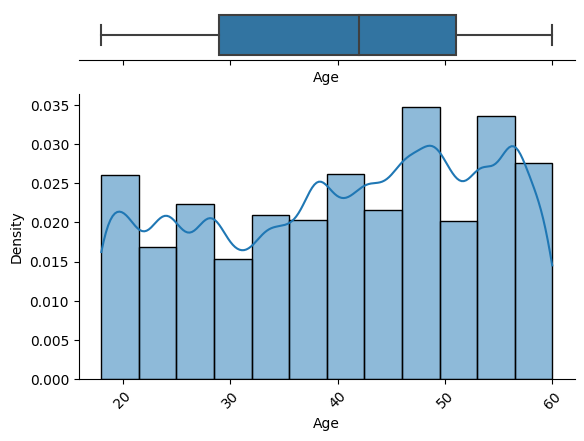

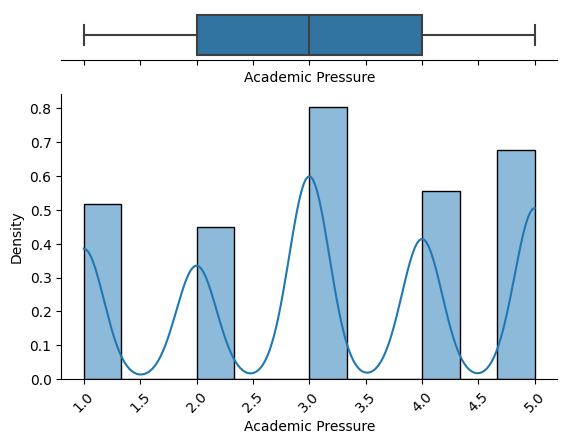

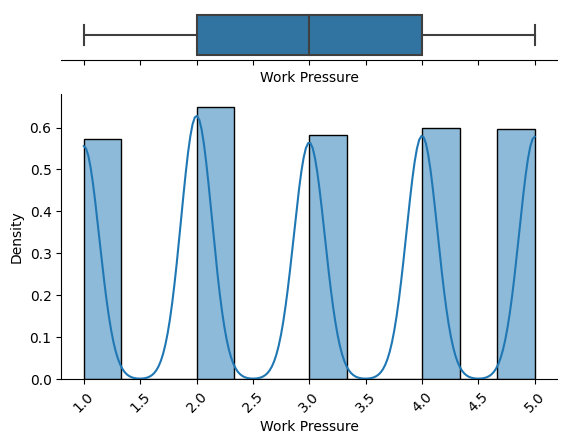

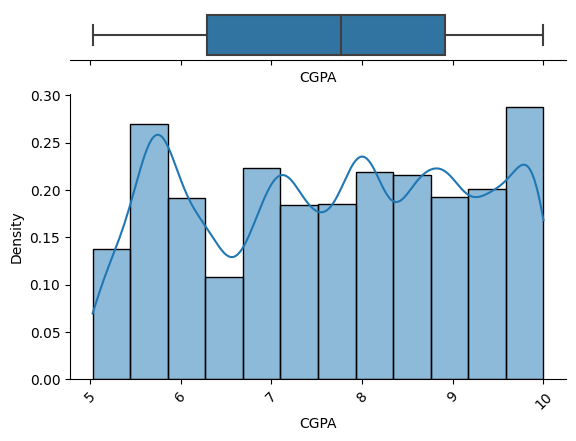

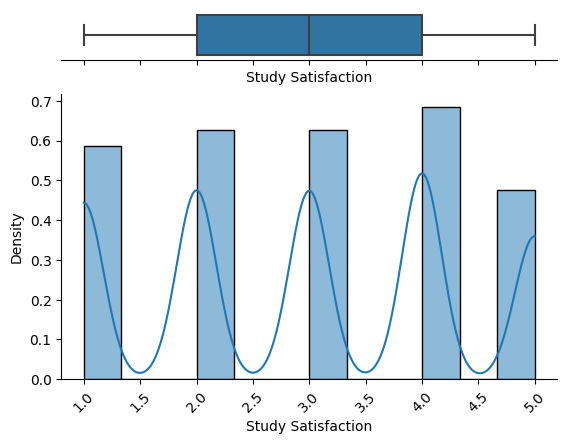

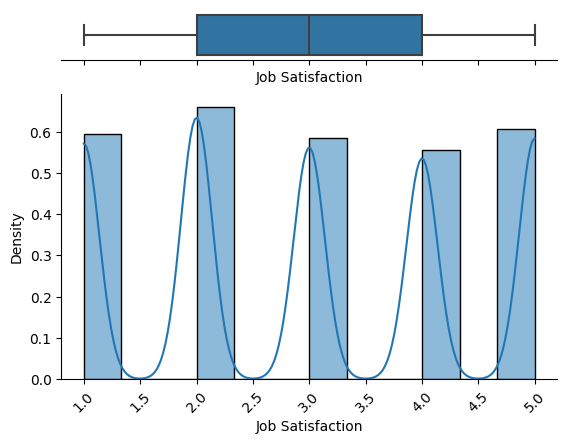

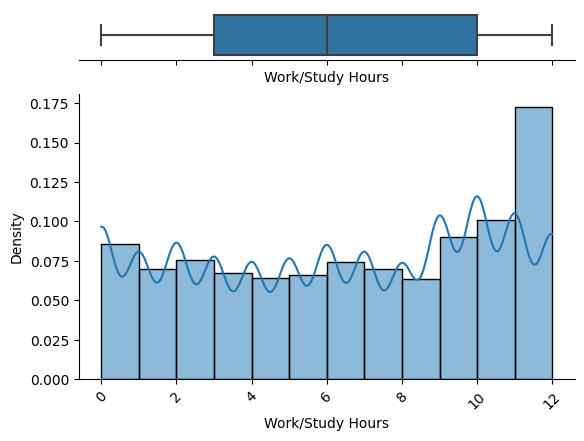

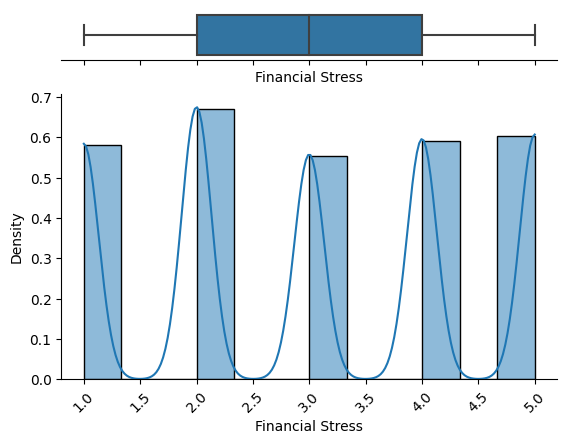

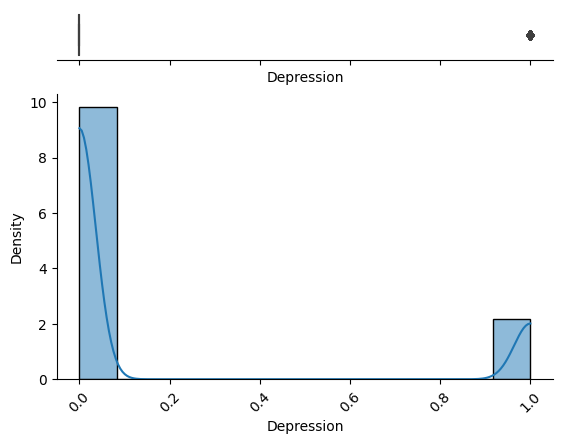

In [11]:
num_feature = train.select_dtypes(include=[np.number]).columns
for i in num_feature:
    plot_box_hist(train[i])

**In general, the data is normal, we see an imbalance in the target, but perhaps we need it to really tune the model**

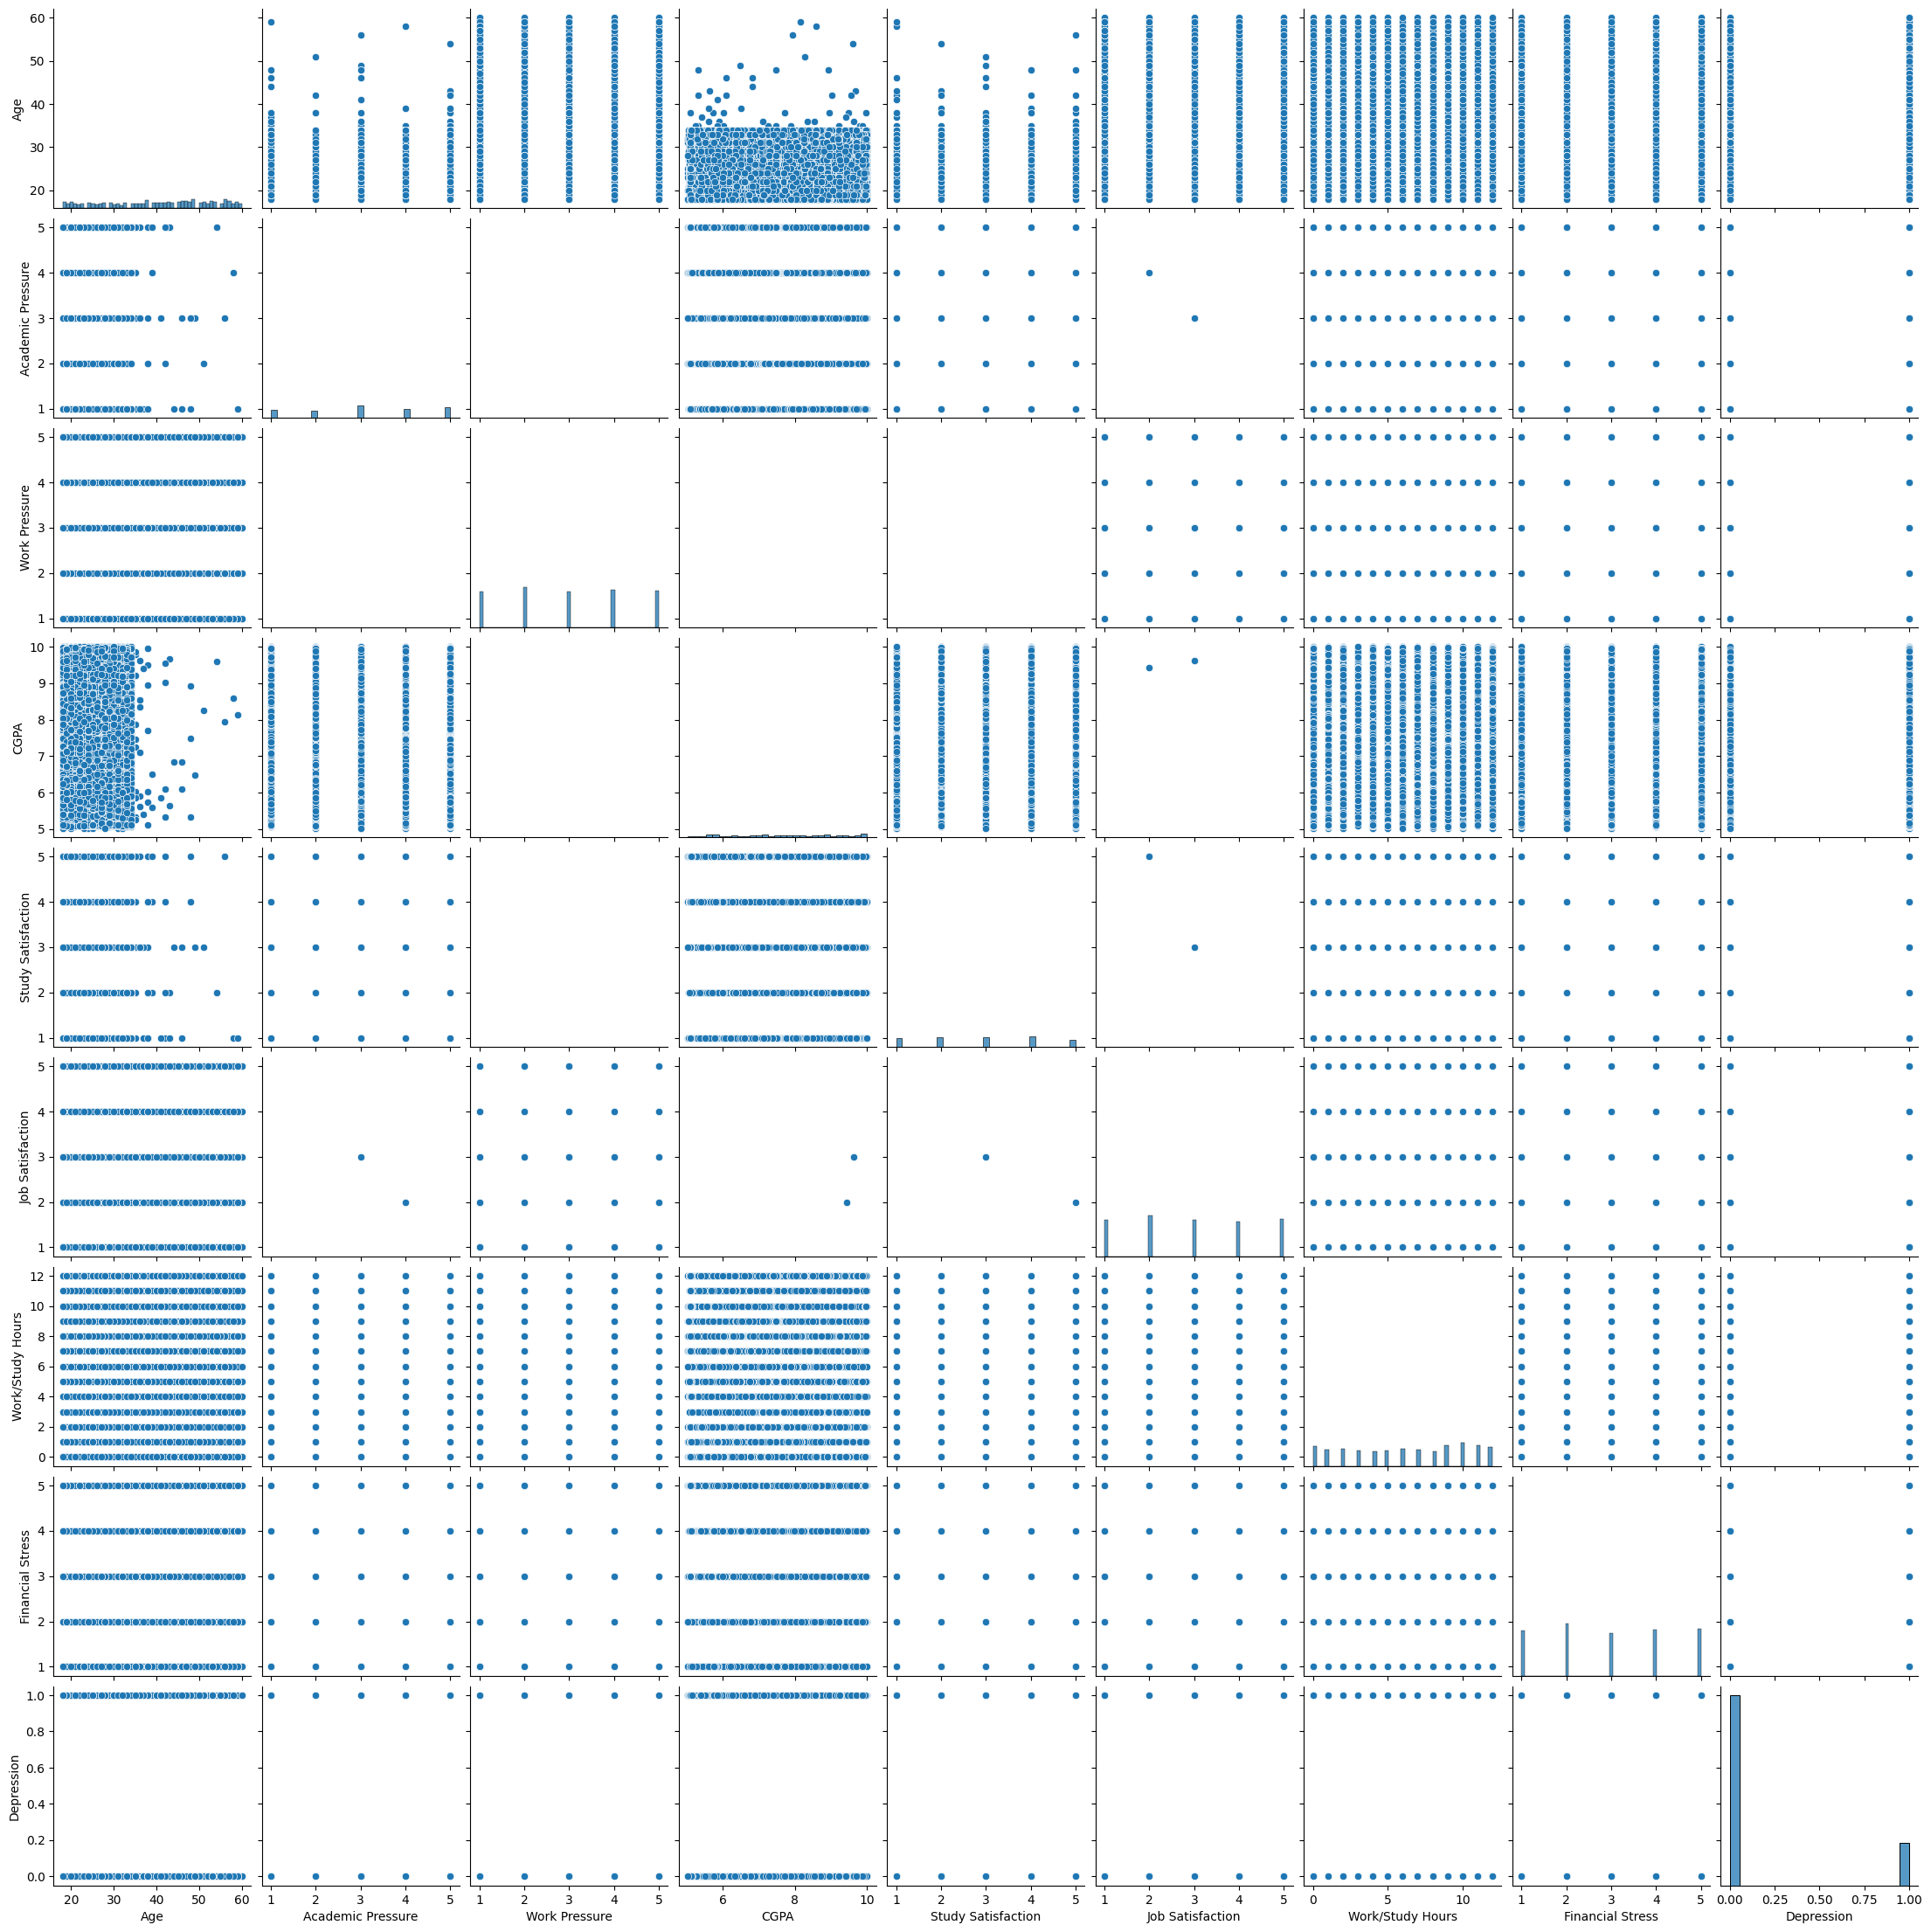

In [12]:
sns.pairplot(train)

**The densities are different, this should be taken into account**

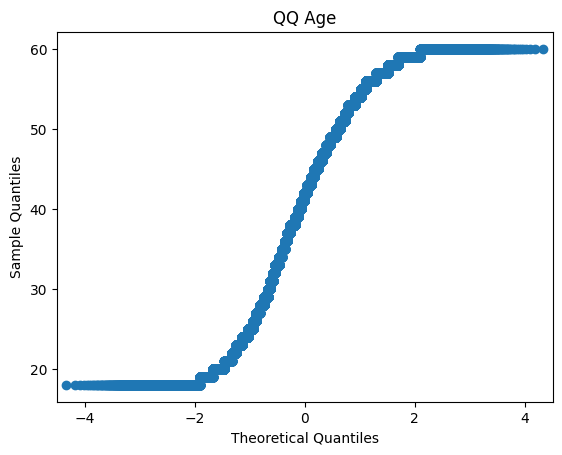

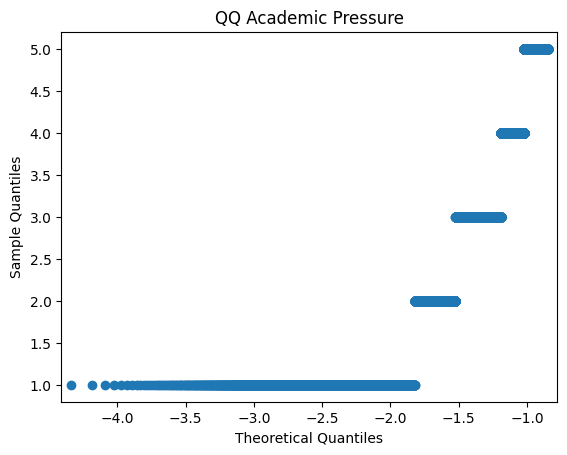

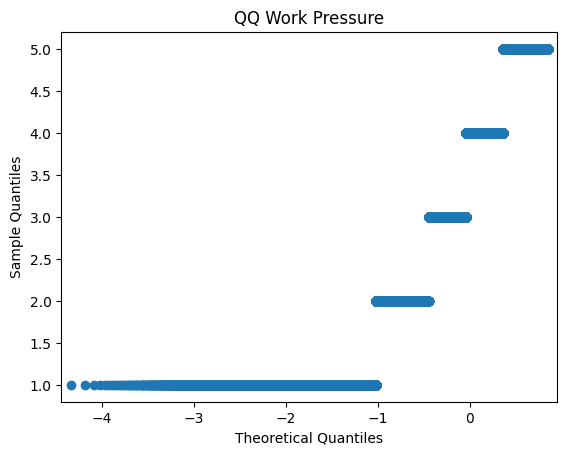

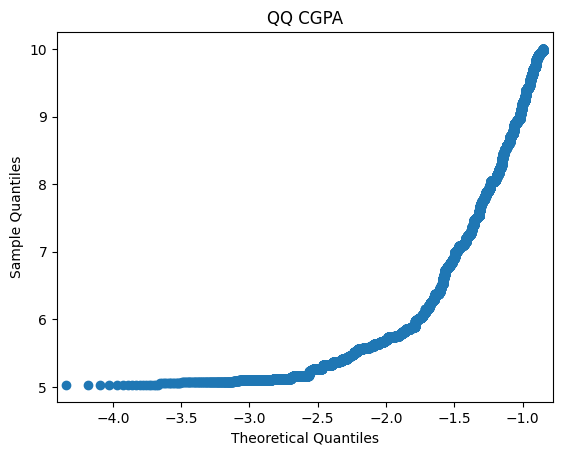

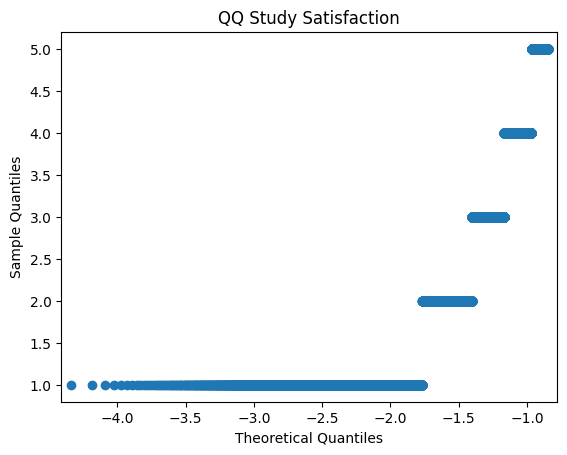

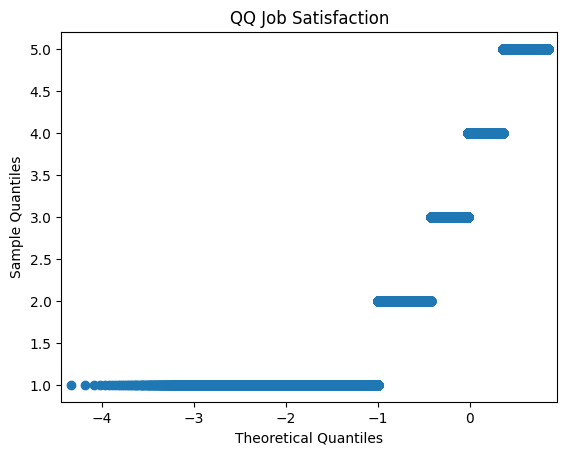

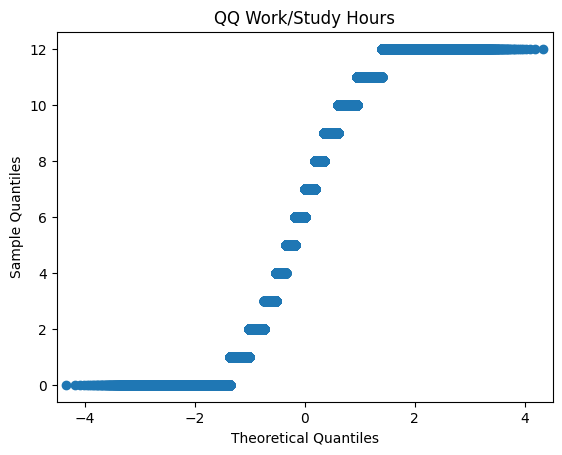

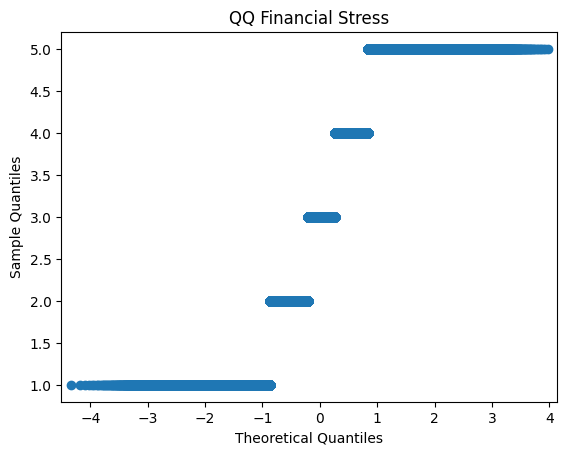

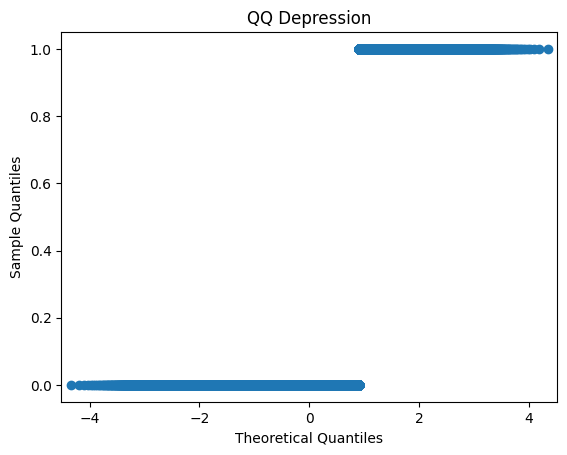

In [13]:
for i in num_feature:
    sm.qqplot(train[i])
    plt.title(f'QQ {i}')
    plt.show()

**t may be necessary to transform the data into a normal state, logarithm it, square it**

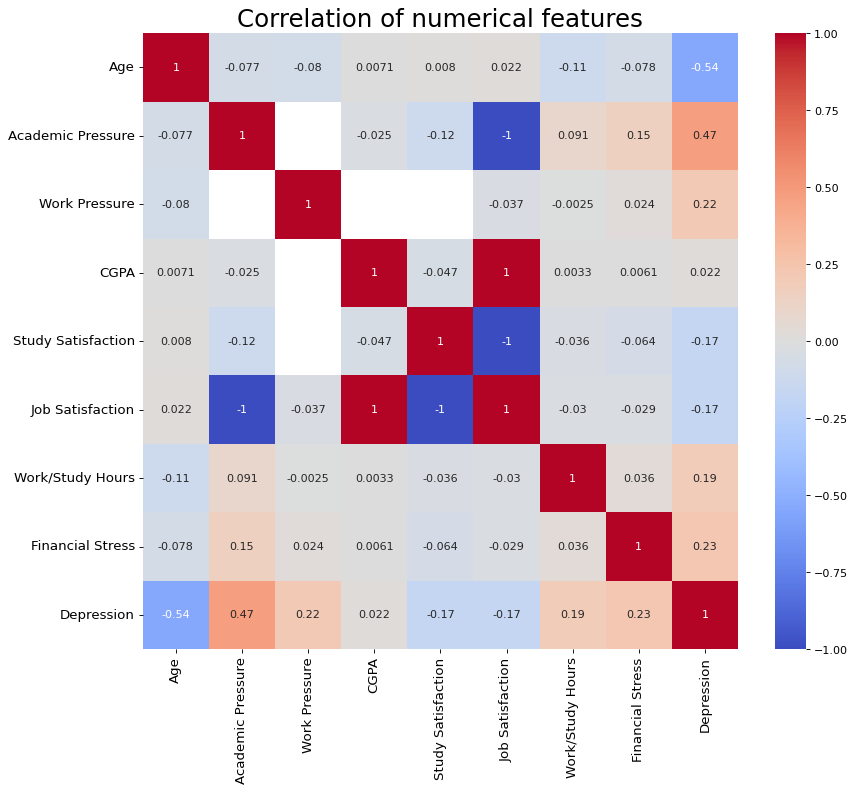

In [14]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train.select_dtypes(include=[np.number]).corr('spearman'),
            xticklabels=train.select_dtypes(include=[np.number]).columns,
            yticklabels=train.select_dtypes(include=[np.number]).columns, 
            cmap='coolwarm', center=0, annot=True)

# Decorations
plt.title('Correlation of numerical features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**The dataset contains negative, weakly negative and weakly positive correlation of features, and strongly positive correlation**

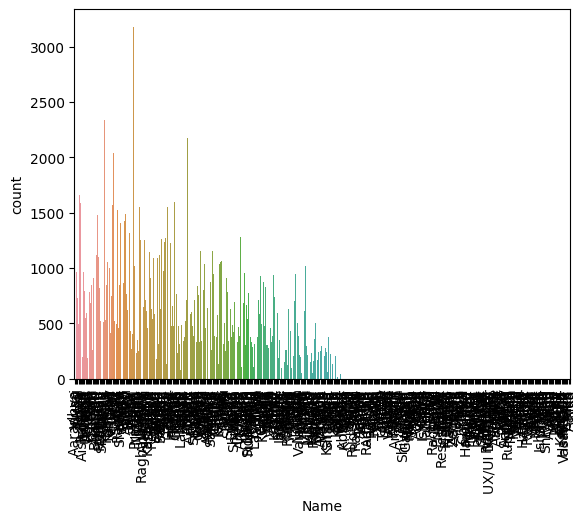

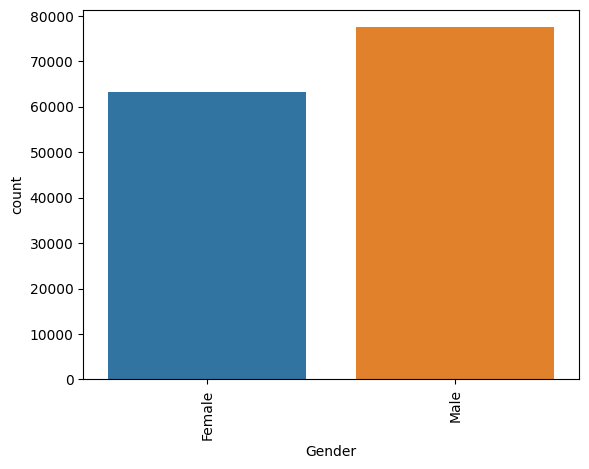

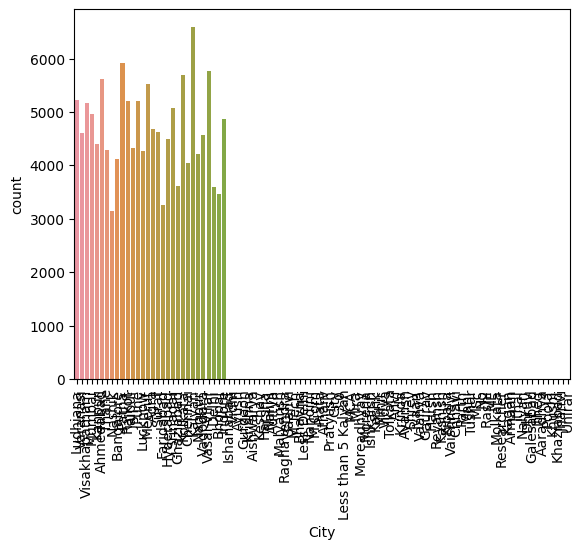

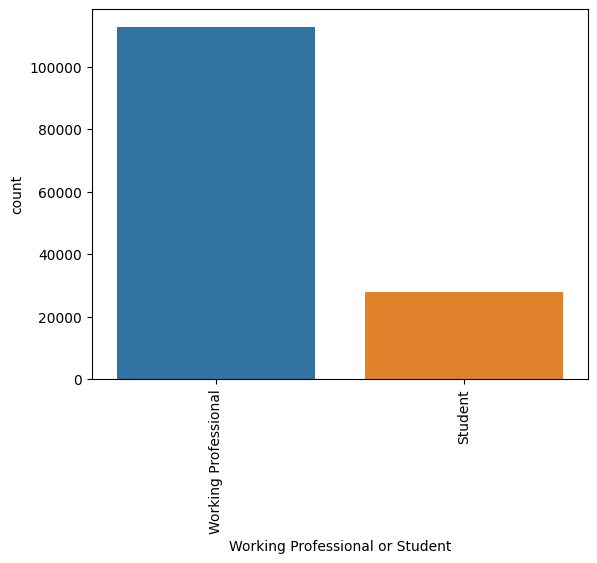

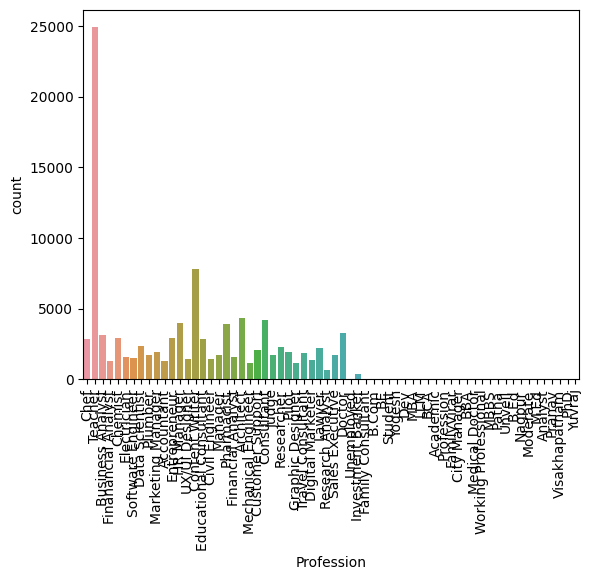

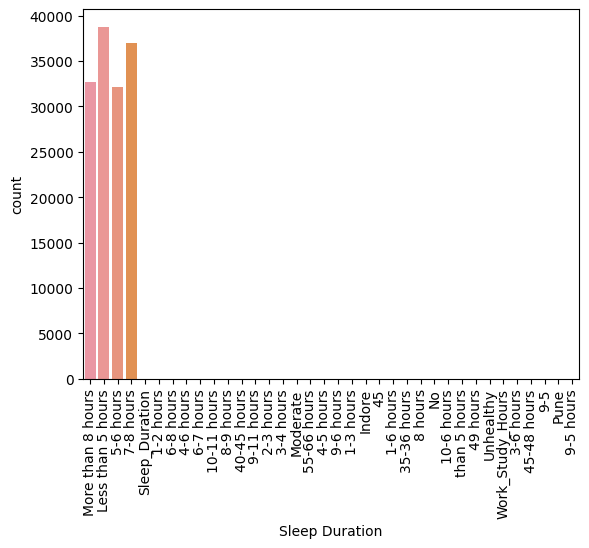

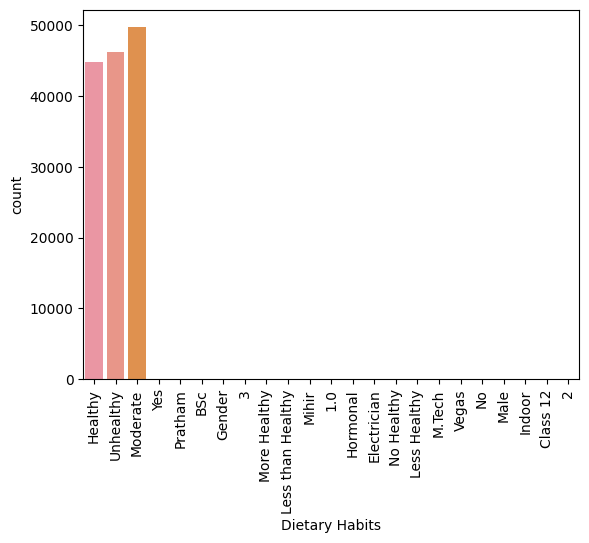

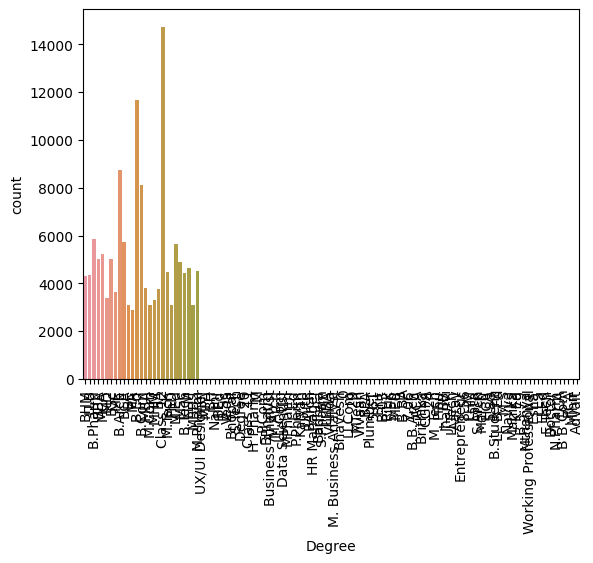

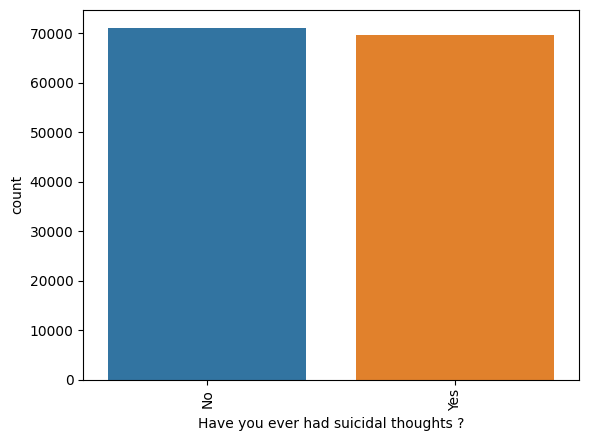

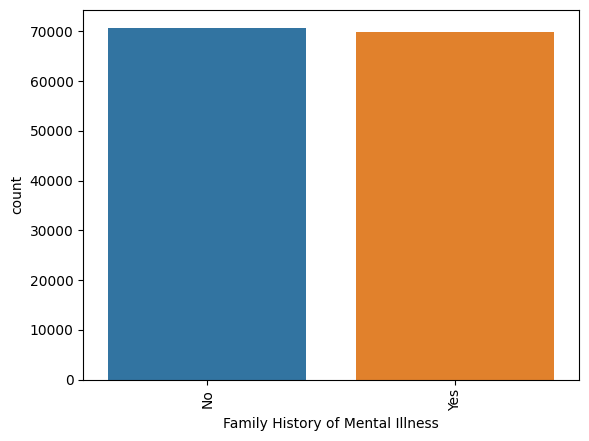

In [15]:
cat_features = train.select_dtypes(include='object').columns

for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=train)
    plt.xticks(rotation=90)
    plt.show()

# Filling in the blanks

**one of the columns has 80% gaps, this is a very dubious decision, but let's try...**

In [16]:
y = train['Depression']
X = train.drop(['Depression'], axis =1)
X.shape, y.shape, test.shape

((140700, 18), (140700,), (93800, 18))

In [17]:
ohe_columns =['Family History of Mental Illness', 'Have you ever had suicidal thoughts ?','Working Professional or Student','Gender']
ord_columns = ['Name', 'Degree','Dietary Habits',  'City', 'Profession', 'Sleep Duration']
num_columns = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
               'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
               'Financial Stress']

In [18]:
ohe_pipe = Pipeline(
    [
        (
            'imputer_ohe', 
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False)
        )
    ]
) 

ord_pipe = Pipeline(
    [
        (
            'imputer_before', 
            SimpleImputer(strategy='most_frequent')
        ),
        ( 
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after', 
            SimpleImputer(strategy='most_frequent')
        )
    ]
) 

num_pipe = Pipeline(
    [
        ('imputer_before_num',
        SimpleImputer(strategy='mean')
        ),
        (
            ('scaler', StandardScaler())
        )
        
    ])

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('imputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Family History of Mental Illness',
                                  'Have you ever had suicidal thoughts ?',
                                  'Working Professional or Student',
                                  'Gender']),
                                ('ord',
                                 Pipeline(steps=[('...
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Name', 'Degree', 'Dietary Habits', 'City',
                                  'Profession', 'Sleep Duration']),
                                ('num', StandardScaler(),
                                 ['Age', 'Academic Pressure', 'Work Pressure',
                                  'CGPA', 'Study Satisfaction',
                                  'Job Satisfaction', 'Work/Study Hours',
                                  'Financial Stress'])])

**prepared the data, filled in the missing values, did one hot encoding, you can build the ml model**

In [19]:
# test = preprocessor.fit_transform(test)
# test.shape

In [20]:
# X = preprocessor.fit_transform(X)
# X.shape

# Model and others

In [21]:
n_splits = 5
random_state = 42
shuffle = True

In [22]:
FOLDs = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

oof_cat = np.zeros(len(X))
predictions_cat = np.zeros(len(test))
oof_xgb = np.zeros(len(X))
predictions_xgb = np.zeros(len(test))
oof_lgb = np.zeros(len(X))
predictions_lgb = np.zeros(len(test))

results = {
    'cat': [],
    'xgb': [],
    'lgb': []
}

classifiers = {}

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X, y)):
    cat_model = Pipeline([('preprocessor', preprocessor),
                          ('cat', CatBoostClassifier(verbose=0))])
    cat_model.fit(X.iloc[trn_idx], y.iloc[trn_idx])
    oof_cat[val_idx] = cat_model.predict(X.iloc[val_idx])
    predictions_cat += cat_model.predict(test) / FOLDs.n_splits
    results['cat'].append(oof_cat[val_idx]) 
    classifiers['cat'] = cat_model  

    cat_score = accuracy_score(oof_cat[val_idx], y.iloc[val_idx])
    print('Fold', fold_, '-- CatBoostClassifier oof accuracy is ---', cat_score)

    xgb_model = Pipeline([('preprocessor', preprocessor),
                          ('xgb', xgb.XGBClassifier())])
    xgb_model.fit(X.iloc[trn_idx], y.iloc[trn_idx])
    oof_xgb[val_idx] = xgb_model.predict(X.iloc[val_idx])
    predictions_xgb += xgb_model.predict(test) / FOLDs.n_splits
    results['xgb'].append(oof_xgb[val_idx])  
    classifiers['xgb'] = xgb_model  

    xgb_score = accuracy_score(oof_xgb[val_idx], y.iloc[val_idx])
    print('Fold', fold_, '-- XGBClassifier oof accuracy is ---', xgb_score)

    lgb_model = Pipeline([('preprocessor', preprocessor),
                          ('lgb', lgb.LGBMClassifier(verbose=-1))])
    lgb_model.fit(X.iloc[trn_idx], y.iloc[trn_idx])
    oof_lgb[val_idx] = lgb_model.predict(X.iloc[val_idx])
    predictions_lgb += lgb_model.predict(test) / FOLDs.n_splits
    results['lgb'].append(oof_lgb[val_idx])  
    classifiers['lgb'] = lgb_model  

    lgb_score = accuracy_score(oof_lgb[val_idx], y.iloc[val_idx])
    print('Fold', fold_, '-- LGBMClassifier oof accuracy is ---', lgb_score)

Fold 0 -- CatBoostClassifier oof accuracy is --- 0.9390547263681592
Fold 0 -- XGBClassifier oof accuracy is --- 0.9379886282871357
Fold 0 -- LGBMClassifier oof accuracy is --- 0.9381307746979389
Fold 1 -- CatBoostClassifier oof accuracy is --- 0.9367093105899076
Fold 1 -- XGBClassifier oof accuracy is --- 0.9366737739872069
Fold 1 -- LGBMClassifier oof accuracy is --- 0.9372423596304194
Fold 2 -- CatBoostClassifier oof accuracy is --- 0.9400497512437811
Fold 2 -- XGBClassifier oof accuracy is --- 0.9386993603411514
Fold 2 -- LGBMClassifier oof accuracy is --- 0.9398720682302771
Fold 3 -- CatBoostClassifier oof accuracy is --- 0.9417199715707179
Fold 3 -- XGBClassifier oof accuracy is --- 0.9395877754086709
Fold 3 -- LGBMClassifier oof accuracy is --- 0.9414356787491116
Fold 4 -- CatBoostClassifier oof accuracy is --- 0.9393745557924662
Fold 4 -- XGBClassifier oof accuracy is --- 0.9373845060412225
Fold 4 -- LGBMClassifier oof accuracy is --- 0.9386993603411514


In [23]:
def objective(trial):
    weights = []
    for _ in range(3):  
        weights.append(trial.suggest_uniform('weight_{}'.format(_), 0, 1))
    weights = np.array(weights)
    
    if np.sum(weights) == 0:
        weights = np.ones_like(weights)  
    weights /= np.sum(weights)  

    y_pred_weighted = np.zeros(len(y), dtype=float)  
    for i, name in enumerate(results.keys()):
        oof_predictions = np.concatenate(results[name]).astype(float)
        
        if oof_predictions.shape[0] != y_pred_weighted.shape[0]:
            raise ValueError(f"Shape mismatch for {name}: {oof_predictions.shape[0]} vs {y_pred_weighted.shape[0]}")

        y_pred_weighted += weights[i] * oof_predictions

    metric = roc_auc_score(y, y_pred_weighted)
    return metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, timeout=600)

best_trial = study.best_trial
optimal_weights = best_trial.params

[I 2024-11-03 19:02:39,418] A new study created in memory with name: no-name-dc1620e0-e603-4406-914e-13fd840e80e7
[I 2024-11-03 19:02:39,456] Trial 0 finished with value: 0.49957444567966924 and parameters: {'weight_0': 0.7028395372746966, 'weight_1': 0.6333460724009002, 'weight_2': 0.695969196031582}. Best is trial 0 with value: 0.49957444567966924.
[I 2024-11-03 19:02:39,492] Trial 1 finished with value: 0.49957017166931683 and parameters: {'weight_0': 0.3336077167993886, 'weight_1': 0.8494408458105488, 'weight_2': 0.08588193498776919}. Best is trial 0 with value: 0.49957444567966924.
[I 2024-11-03 19:02:39,527] Trial 2 finished with value: 0.4995693852187989 and parameters: {'weight_0': 0.835102543074819, 'weight_1': 0.9875134773006311, 'weight_2': 0.5816545923045797}. Best is trial 0 with value: 0.49957444567966924.
[I 2024-11-03 19:02:39,562] Trial 3 finished with value: 0.49957444567966924 and parameters: {'weight_0': 0.9587075675675625, 'weight_1': 0.4460591397704333, 'weight_2'

In [24]:
y_pred_test_final = np.zeros(len(test))

for i, (name, clf) in enumerate(classifiers.items()):
    y_pred_test = clf.predict_proba(test)[:, 1]  
    y_pred_test_final += optimal_weights['weight_{}'.format(i)] * y_pred_test

threshold = 0.5  
y_pred_classes = (y_pred_test_final >= threshold).astype(int)

print("Final predictions (classes):", y_pred_classes)

Final predictions (classes): [0 0 0 ... 0 1 0]


# Submit

In [25]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sub['Depression'] = y_pred_classes
sub.to_csv('submission.csv', index=False)